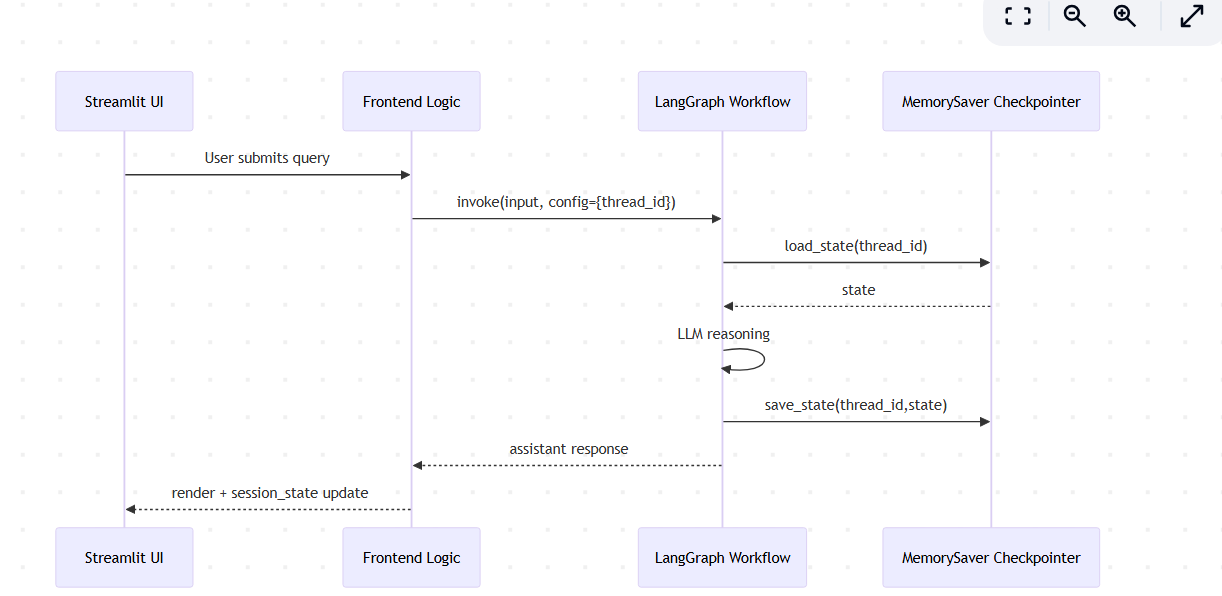

## Architecture

Two-layer architecture implementing a terminal chatbot as a web application:

Backend: LangGraph workflow with persistent LLM memory
Frontend: Streamlit UI with session persistence and message rendering

```
+-------------------------+           +---------------------------+
|   Streamlit Frontend    |  HTTPS    |   LangGraph Backend       |
| (st.session_state)      |---------> | (MemorySaver Checkpoint)  |
|  UI Memory (Ephemeral)  | <---------|  LLM Memory (Persistent)  |
+-------------------------+           +---------------------------+
```

### Data Flow

1. UI loads and replays chat history from `st.session_state`
2. User submits query
3. Frontend sends query → backend using invoke with `thread_id`
4. Backend retrieves state via MemorySaver
5. LLM produces output
6. Frontend renders output and stores it into session state

### Memory Model

UI persistence constraint:
Streamlit re-executes script on each event → must store history in `st.session_state`

LLM persistence constraint:
LangGraph state requires checkpointer+thread for context retention

### Trust Boundaries

TLS 1.3 enforced between layers
Frontend does not store model secrets or tokens
Backend isolates secrets using environment variables
No direct DB exposure to UI


---

## Backend Implementation (`langgraph_backend.py`)

Requirements:

```
langgraph==0.1.43
langchain==0.3.8
langchain-openai==0.2.2
```

Backend is deterministic, stateless between invocations except via MemorySaver.

```python
from langgraph.graph import MessageGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

memory = MemorySaver()
graph = MessageGraph()

@graph.add_node
def chatbot(state):
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

graph.set_entry_point("chatbot")
workflow = graph.compile(checkpointer=memory)
```

---

## Frontend Implementation (`streamlit_frontend.py`)

Requirements:

```
streamlit==1.41.1
```

### Initialization

```python
import streamlit as st
from langchain.schema import HumanMessage
from langgraph_backend import workflow

if "message_history" not in st.session_state:
    st.session_state.message_history = []
```

### Display History

```python
for role, content in st.session_state.message_history:
    with st.chat_message(role):
        st.write(content)
```

### Capture Input

```python
user_input = st.chat_input("Message")
```

### Backend Invocation (with persistent thread)

```python
if user_input:
    st.session_state.message_history.append(("user", user_input))

    human = HumanMessage(content=user_input)

    result = workflow.invoke(
        input={"messages": [human]},
        config={"configurable": {"thread_id": "session_001"}}
    )

    ai_msg = result["messages"][-1].content
    st.session_state.message_history.append(("assistant", ai_msg))
```

### Render New Output

```python
with st.chat_message("assistant"):
    st.write(ai_msg)
```

---

## Build + Deployment

Environment:

```
Python 3.11.7
pip-tools for locking
TLS 1.3 enforced at ingress
```

Reproducible build:

```
pip-compile requirements.in
pip-sync
```

Deployment (FastAPI backend + Streamlit frontend):

```
docker build -t chatbot .
docker run -p 443:443 --env-file .env chatbot
```

Rollback strategy:

Container orchestration via rolling update with health probes and traffic draining; last stable tag kept for revert.

---

## Observability

Metrics:

* Request latency
* LLM token usage
* MemorySaver checkpoint hit rate
* UI error rate

Logs exported via OpenTelemetry → Prometheus/Grafana

---

## Tests

Unit test (UI memory)

```python
def test_session_persistence():
    state = []
    state.append(("user","hi"))
    assert state[-1][0] == "user"
```

Integration test (backend context)

```python
res1 = workflow.invoke({"messages":[HumanMessage("hi")]},
    config={"configurable":{"thread_id":"t"}})
res2 = workflow.invoke({"messages":[HumanMessage("how are you?")]},
    config={"configurable":{"thread_id":"t"}})
assert len(res2["messages"])>1
```

Failure-mode test:

* backend unreachable → UI local history still renders without crash

---

